In [ ]:
import sys
sys.path
sys.path.append('/volatile/aurelien_stumpf_mascles/project/code/')

In [66]:
import sys

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import torch 
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
import cebra_v2 as cebra2 
import cebra

In [65]:
import importlib
importlib.reload(cebra2)

<module 'cebra_v2' from '/home/aurel/Bureau/Stage_Neurospin/Code/PROJECT/notebook/cebra_v2/__init__.py'>

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [4]:
cortex = 'VISp'
seed=333
num_neurons = 800

ca_train = cebra.datasets.init(f'allen-movie-one-ca-{cortex}-{num_neurons}-train-10-{seed}')
np_train = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')
joint_train = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')

ca_test = cebra.datasets.init(f'allen-movie-one-ca-{cortex}-{num_neurons}-test-10-{seed}')
np_test = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')
joint_test = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')


Text(0.5, 1.0, 'Neuropixels')

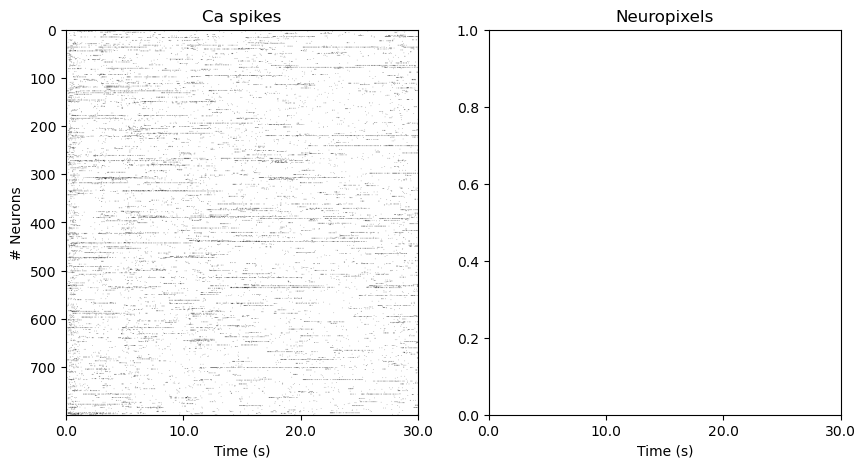

In [5]:
plt.figure(figsize=(10,5))
ax1= plt.subplot(1,2,1)
ax1.imshow(ca_train.neural.cpu().numpy()[:900].T, aspect = 'auto', vmax = 1, vmin = 0, cmap ='gray_r')
ax1.set_ylabel('# Neurons')
ax1.set_xlabel('Time (s)')
ax1.set_xticks(np.linspace(0,900, 4))
ax1.set_xticklabels(np.linspace(0,30, 4))
ax1.set_title('Ca spikes')
ax2= plt.subplot(1,2,2)
ax2.set_xlabel('Time (s)')
ax2.set_xticks(np.linspace(0,3600, 4))
ax2.set_xticklabels(np.linspace(0,30, 4))
ax2.set_title('Neuropixels')

In [5]:
len(ca_train)

8100

In [67]:
num_output = 3
normalize = True

model = cebra2.model.Model(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(
        num_neurons,
        num_output * 30,
    ),
    nn.GELU(),
    nn.Linear(num_output * 30, num_output * 30),
    nn.GELU(),
    nn.Linear(num_output * 30, num_output * 10),
    nn.GELU(),
    nn.Linear(int(num_output * 10), num_output),
    num_input=num_neurons,
    num_output=num_output,
    normalize=normalize,
        )

In [68]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.InfoNCE(temperature=kwargs['temperature'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

In [50]:
@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset[torch.arange(len(dataset))].to(device)).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

In [71]:
ca_loader = cebra2.dataset.Loader(ca_train, num_steps = 10000, batch_size = 512)
np_loader = cebra2.dataset.Loader(np_train, num_steps = 10000, batch_size = 512)

In [72]:
cebra_ca = single_session_solver(data_loader = ca_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, learning_rate = 3e-2, model = model)

In [73]:
cebra_ca.fit(ca_loader)

Epoch 0
Train loss 6.2383, Train accuracy 0.00%


KeyboardInterrupt: 

(-1.096638759970665,
 1.0316903799772263,
 -1.0669067680835724,
 0.9955765783786774)

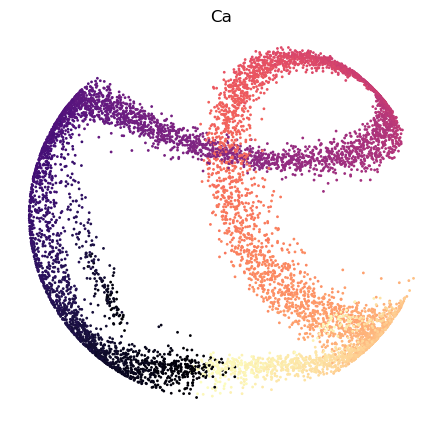

In [54]:
cebra_ca_emb = _compute_emissions_single(cebra_ca, ca_train)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Ca')
ax1.scatter(cebra_ca_emb[:,0], cebra_ca_emb[:,1], cmap = 'magma', c = np.tile(np.arange(900),9), s=1)
ax1.axis('off')